# <p style='text-align: center;'> Solar Irradiance Prediction Based on Weather Patterns Using Bagging-Based Ensemble Learners with Principal Component Analysis </p>
    
<p style='text-align: justify;'>&emsp;Energy production of photovoltaic (PV) system depends on the amount of solar irradiance present on a certain location. Accurate prediction of solar irradiance ensures economic integration of PV system to grid and leads to optimal dispatching of available energy resources. Weather conditions has strong correlation with solar irradiance, and its erratic nature causes fluctuation to energy production. Therefore, it is difficult to achieve consistent optimal energy production and reliable prediction of solar irradiance </p>

<p style='text-align: justify;'>&emsp; In the study, a bagging-based ensemble learning system was used to predict solar irradiance based on weather patterns. Previous researches confirmed that ensemble learners produced unbiased and more accurate results compared to single learners. A pre-processed stacked long-short term memory model (stacked LSTM) was used as base learner in ensemble learning since it has good performance in handling time series sequences. A plot that compares the performance between single learner and ensemble learners was provided. </p>

<p style='text-align: justify;'>&emsp; From the plot, it shows that at some iteration, ensemble learners get consistent at providing more accurate predictions compared to single learners. Metrics used in the study include explained variance score, maximum residual error, mean absolute error, mean squared error, and regression score function.</p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
from sklearn.decomposition import PCA
from sklearn import metrics

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional

In [5]:
from sklearn.utils import resample
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array

In [6]:
from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

In [7]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

**Long SHort Term Memory**

<p style='text-align: justify;'>&emsp; Long short-term memory is suitable for handling time series data because it is capable to store information at any arbitrary period. It is also faster to converge compared to recurrent neural network (RNN). LSTM consists of input gate it, output gate ot and forget gate ft which manage the information coming in and out of memory cell, and memory cell which is responsible for handling vanishing gradient problem. Each gate possesses activation function which receives the same input as input neurons. Rectified linear unit (ReLu) was used as an activation function because it is simpler to use compared to sigmoid function and produces better results. Stacked LSTM uses 2 LSTM layers with 64 neurons that serve as memory units.  </p>

In [8]:
def evaluate_model(trainX, trainy, testX,testY):
    
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(4,1)))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))
   
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    model.fit(trainX, trainy, epochs=1000, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    
    return model


In [9]:
df= pd.read_csv("weather3.csv")

**Correlation Map**

<p style='text-align: justify;'>&emsp; The darkest color indicates strong inverse relationship, otherwise it possesses strong direct relationship between two variables. It is reported that solar irradiance correlates strongly with ambient light and ambient temperature, having a regression coefficient of 0.94 and 0.77, respectively. It implies that as the temperature goes warmer, the sunlight intensifies as well as the ambient light.</p>

<p style='text-align: justify;'>&emsp; Also, solar irradiance shows strong negative correlation with humidity, having a regression coefficient of -0.82. Humidity is associated with rainfall and high value of it is due to evaporation. Rainfall results to reduced sunlight intensity and ambient temperature. Lastly, solar irradiance has weak negative correlation with windspeed, having a regression coefficient of -0.19. Windspeed has weak direct relationship with humidity, sea level pressure and absolute pressure having regression coefficient values of 0.1836, 0.2161, and 0.2159, respectively. It means that there’s a chance of having reduced sunlight intensity if there is a strong windspeed due to high atmospheric pressure and humidity </p>

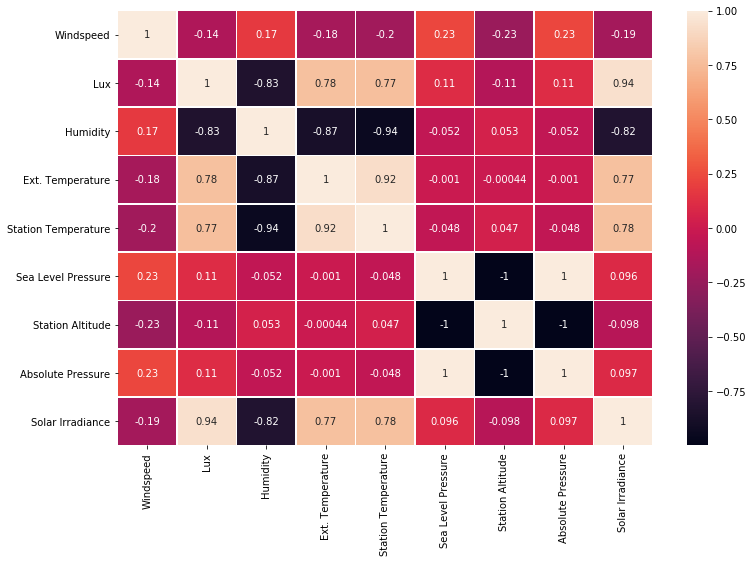

In [10]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True, linewidth=0.5)

In [11]:
#Split dataset into training and testing set

train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)
    
train_stats = train_dataset.describe()
train_stats.pop("Solar Irradiance")
train_stats = train_stats.transpose()
    
train_labels = train_dataset.pop('Solar Irradiance')
test_labels = test_dataset.pop('Solar Irradiance')

In [12]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
    
train_final= normed_train_data.values
test_final = normed_test_data.values
target=train_labels.values
test_target=test_labels.values

**Principal Component Analysis**

<p style='text-align: justify;'>&emsp; In the study, principal component analysis was applied in order to reduce the size of input dataset without compromising its information. This also reduce the likelihood of overfitting the data, as well as minimizing the computational time requirement during model training </p>

In [14]:
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(train_final)
    
pca_train = pca.transform(train_final)
pca_test = pca.transform(test_final)

In [15]:
X_train = np.expand_dims(pca_train, axis=2)
X_test = np.expand_dims(pca_test, axis=2)

**Bagging Method**

<p style='text-align: justify;'>&emsp; A for-loop method was used in implementing the bagging method by setting a control number equal to the number of base learners. In the study, there are 20 base learners in an ensemble. Inside the iteration, the input dataset is resampled randomly and is later used for model training. The prediction made by the fitted model is saved on an array and the iteration will stop until it reached 20th iteration. The predictions made by ensemble learners in each iteration is averaged and is evaluated by metrics applicable in regression problems. A plot of performance comparison between ensemble learners and single learner is provided for further analysis </p>

In [17]:
n_splits = 20
members = list()

for _ in range(n_splits):
    model = evaluate_model(X_train, target, X_test, test_target)
    members.append(model)


Epoch: 0, loss:204624.1250,  mae:335.3143,  mse:204624.1250,  val_loss:40370.2852,  val_mae:150.5346,  val_mse:40370.2852,  
....................................................................................................
Epoch: 100, loss:8159.7734,  mae:50.6133,  mse:8159.7734,  val_loss:9712.5176,  val_mae:50.1953,  val_mse:9712.5176,  
...............................
Epoch: 0, loss:193808.3125,  mae:327.7590,  mse:193808.3125,  val_loss:40278.1484,  val_mae:148.7898,  val_mse:40278.1484,  
....................................................................................................
Epoch: 100, loss:8128.5112,  mae:49.1543,  mse:8128.5112,  val_loss:8724.6094,  val_mae:48.0800,  val_mse:8724.6094,  
......
Epoch: 0, loss:190693.3750,  mae:322.2191,  mse:190693.3750,  val_loss:34934.9883,  val_mae:138.2930,  val_mse:34934.9883,  
..........................................................................
Epoch: 0, loss:195343.9844,  mae:326.8244,  mse:195343.9844,  val_loss

**Results**

<p style='text-align: justify;'>&emsp; The following section shows the plot that shows comparison of the performance between single learners and ensemble learners using the metrics regression score, explained variance score, root mean squared error, mean absolute error, and maximum residual error. The plots for the said metrics are arranged from top to bottom. It can be observed from the plot the downward trend of ensemble learners at the 10th iteration. </p>

<p style='text-align: justify;'>&emsp; It implies that as iteration increases, the value of error starts to decrease. This can also imply the improvement of accuracy in prediction in comparison with the individual learners. It is noticeable the consistency of the performance of ensemble learners compared to single learner Using the mean absolute error and root mean squared error as metric, the ensemble learners became stable and consistent at 10th iteration. Meanwhile, by using the maximum residual error as y-axis, the ensemble learner starts to become consistent at around 6th iteration. </p>

<p style='text-align: justify;'>&emsp; There are some points of iterations where single learner outperforms ensemble learners, however, its performance is not consistent. At average, the explained variance score and regression score of ensemble learners average around 0.92, which indicates high estimation of true values found in input sequence. </p>


In [20]:
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
    subset = members[:i]
    yhats = [model.predict(X_test) for model in subset]
    yhats = array(yhats)
    averaged = np.average(yhats, axis=0)
    ensemble = r2_score(test_target,averaged)
    
    *_, y1 = [members[i-1].predict(X_test)]
    single =  r2_score(test_target,y1)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single, ensemble))
    single_scores.append(single)
    ensemble_scores.append(ensemble)
    
   

> 1: single=0.924, ensemble=0.924
> 2: single=0.922, ensemble=0.929
> 3: single=0.914, ensemble=0.927
> 4: single=0.908, ensemble=0.924
> 5: single=0.923, ensemble=0.925
> 6: single=0.921, ensemble=0.926
> 7: single=0.925, ensemble=0.927
> 8: single=0.928, ensemble=0.929
> 9: single=0.927, ensemble=0.930
> 10: single=0.923, ensemble=0.930
> 11: single=0.911, ensemble=0.929
> 12: single=0.922, ensemble=0.929
> 13: single=0.899, ensemble=0.929
> 14: single=0.928, ensemble=0.929
> 15: single=0.919, ensemble=0.929
> 16: single=0.917, ensemble=0.929
> 17: single=0.908, ensemble=0.929
> 18: single=0.931, ensemble=0.929
> 19: single=0.915, ensemble=0.929
> 20: single=0.917, ensemble=0.929


r2_score 0.919 (0.008)
r2_score 0.928 (0.002)


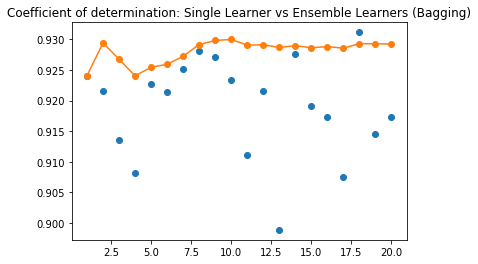

In [21]:
# plot score vs number of ensemble members
print('r2_score %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
print('r2_score %.3f (%.3f)' % (mean(ensemble_scores), std(ensemble_scores)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
plt.title("Coefficient of determination: Single Learner vs Ensemble Learners (Bagging)")
pyplot.show()

In [22]:
single_mse, ensemble_mse = list(), list()
for i in range(1, n_splits+1):
    subset = members[:i]
    yhats = [model.predict(X_test) for model in subset]
    yhats = array(yhats)
    averaged = np.average(yhats, axis=0)
    ensemble = mean_squared_error(test_target,averaged,squared=False)
    
    *_, y1 = [members[i-1].predict(X_test)]
    single =  mean_squared_error(test_target,y1,squared=False)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single, ensemble))
    single_mse.append(single)
    ensemble_mse.append(ensemble)
   

> 1: single=92.731, ensemble=92.731
> 2: single=94.236, ensemble=89.402
> 3: single=98.924, ensemble=91.077
> 4: single=101.994, ensemble=92.750
> 5: single=93.558, ensemble=91.885
> 6: single=94.383, ensemble=91.592
> 7: single=92.052, ensemble=90.777
> 8: single=90.233, ensemble=89.571
> 9: single=90.895, ensemble=89.153
> 10: single=93.184, ensemble=89.042
> 11: single=100.318, ensemble=89.635
> 12: single=94.206, ensemble=89.594
> 13: single=107.008, ensemble=89.874
> 14: single=90.521, ensemble=89.685
> 15: single=95.735, ensemble=89.906
> 16: single=96.798, ensemble=89.782
> 17: single=102.301, ensemble=89.951
> 18: single=88.294, ensemble=89.484
> 19: single=98.389, ensemble=89.493
> 20: single=96.728, ensemble=89.518


RMSE Single Learners 95.625 (4.615)
RMSE Ensemble Learners 90.245 (1.120)


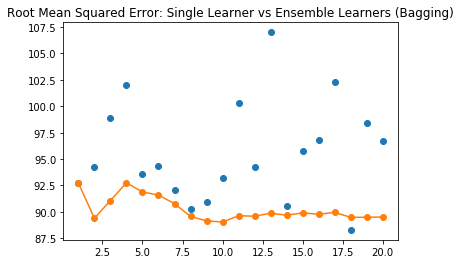

In [23]:
# plot score vs number of ensemble members
print('RMSE Single Learners %.3f (%.3f)' % (mean(single_mse), std(single_mse)))
print('RMSE Ensemble Learners %.3f (%.3f)' % (mean(ensemble_mse), std(ensemble_mse)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_mse, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_mse, marker='o')
plt.title("Root Mean Squared Error: Single Learner vs Ensemble Learners (Bagging)")
pyplot.show()

In [24]:
single_mae, ensemble_mae = list(), list()
for i in range(1, n_splits+1):
    subset = members[:i]
    yhats = [model.predict(X_test) for model in subset]
    yhats = array(yhats)
    averaged = np.average(yhats, axis=0)
    ensemble = mean_absolute_error(test_target,averaged)
    
    *_, y1 = [members[i-1].predict(X_test)]
    single =  mean_absolute_error(test_target,y1)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single, ensemble))
    single_mae.append(single)
    ensemble_mae.append(ensemble)
   

> 1: single=48.784, ensemble=48.784
> 2: single=61.850, ensemble=50.509
> 3: single=64.474, ensemble=53.655
> 4: single=72.977, ensemble=57.670
> 5: single=53.740, ensemble=54.455
> 6: single=52.101, ensemble=53.326
> 7: single=50.242, ensemble=51.322
> 8: single=53.941, ensemble=51.090
> 9: single=49.958, ensemble=49.955
> 10: single=48.491, ensemble=49.166
> 11: single=55.887, ensemble=49.453
> 12: single=52.083, ensemble=48.977
> 13: single=69.410, ensemble=49.857
> 14: single=52.819, ensemble=49.827
> 15: single=61.754, ensemble=50.255
> 16: single=48.724, ensemble=49.553
> 17: single=53.619, ensemble=49.122
> 18: single=48.566, ensemble=48.444
> 19: single=52.491, ensemble=48.013
> 20: single=54.934, ensemble=47.951


MAE Single Learners 55.342 (6.907)
MAE Ensemble Learners 50.569 (2.398)


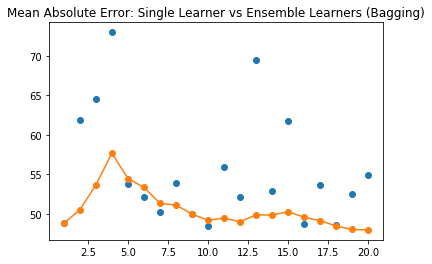

In [25]:
# plot score vs number of ensemble members
print('MAE Single Learners %.3f (%.3f)' % (mean(single_mae), std(single_mae)))
print('MAE Ensemble Learners %.3f (%.3f)' % (mean(ensemble_mae), std(ensemble_mae)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_mae, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_mae, marker='o')
plt.title("Mean Absolute Error: Single Learner vs Ensemble Learners (Bagging)")
pyplot.show()

In [26]:
single_maxe, ensemble_maxe = list(), list()
for i in range(1, n_splits+1):
    subset = members[:i]
    yhats = [model.predict(X_test) for model in subset]
    yhats = array(yhats)
    averaged = np.average(yhats, axis=0)
    ensemble = max_error(test_target,averaged)
    
    *_, y1 = [members[i-1].predict(X_test)]
    single =  max_error(test_target,y1)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single, ensemble))
    single_maxe.append(single)
    ensemble_maxe.append(ensemble)
   

> 1: single=729.729, ensemble=729.729
> 2: single=705.886, ensemble=717.808
> 3: single=701.848, ensemble=712.488
> 4: single=670.617, ensemble=702.020
> 5: single=745.110, ensemble=710.638
> 6: single=740.329, ensemble=715.586
> 7: single=726.111, ensemble=717.090
> 8: single=702.343, ensemble=715.247
> 9: single=773.521, ensemble=721.722
> 10: single=758.062, ensemble=725.356
> 11: single=738.630, ensemble=726.562
> 12: single=763.960, ensemble=729.679
> 13: single=673.506, ensemble=725.358
> 14: single=742.615, ensemble=726.590
> 15: single=707.894, ensemble=725.344
> 16: single=817.977, ensemble=731.134
> 17: single=769.569, ensemble=733.394
> 18: single=768.523, ensemble=735.346
> 19: single=796.741, ensemble=738.577
> 20: single=771.720, ensemble=740.234


Max Error Single Learners 740.235 (37.851)
Max Error Ensemble Learners 723.995 (9.645)


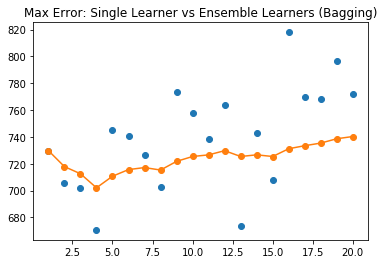

In [27]:
# plot score vs number of ensemble members
print('Max Error Single Learners %.3f (%.3f)' % (mean(single_maxe), std(single_maxe)))
print('Max Error Ensemble Learners %.3f (%.3f)' % (mean(ensemble_maxe), std(ensemble_maxe)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_maxe, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_maxe, marker='o')
plt.title("Max Error: Single Learner vs Ensemble Learners (Bagging)")
pyplot.show()    

In [28]:
single_evs, ensemble_evs = list(), list()
for i in range(1, n_splits+1):
    subset = members[:i]
    yhats = [model.predict(X_test) for model in subset]
    yhats = array(yhats)
    averaged = np.average(yhats, axis=0)
    ensemble = explained_variance_score(test_target,averaged)
    
    *_, y1 = [members[i-1].predict(X_test)]
    single =  explained_variance_score(test_target,y1)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single, ensemble))
    single_evs.append(single)
    ensemble_evs.append(ensemble)
   

> 1: single=0.926, ensemble=0.926
> 2: single=0.929, ensemble=0.930
> 3: single=0.920, ensemble=0.928
> 4: single=0.921, ensemble=0.927
> 5: single=0.923, ensemble=0.927
> 6: single=0.921, ensemble=0.927
> 7: single=0.927, ensemble=0.928
> 8: single=0.933, ensemble=0.930
> 9: single=0.928, ensemble=0.930
> 10: single=0.925, ensemble=0.930
> 11: single=0.911, ensemble=0.929
> 12: single=0.924, ensemble=0.929
> 13: single=0.913, ensemble=0.929
> 14: single=0.928, ensemble=0.929
> 15: single=0.922, ensemble=0.929
> 16: single=0.923, ensemble=0.929
> 17: single=0.914, ensemble=0.929
> 18: single=0.933, ensemble=0.929
> 19: single=0.922, ensemble=0.929
> 20: single=0.918, ensemble=0.929


Explained Variance Score Single Learners 0.923 (0.006)
Explained Variance Score Ensemble Learners 0.929 (0.001)


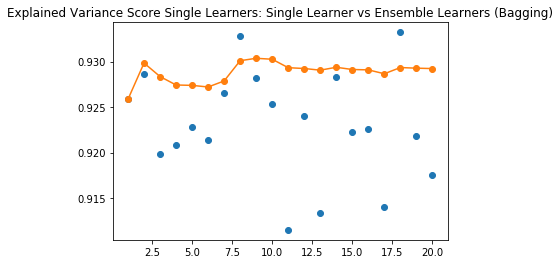

In [29]:
# plot score vs number of ensemble members
print('Explained Variance Score Single Learners %.3f (%.3f)' % (mean(single_evs), std(single_evs)))
print('Explained Variance Score Ensemble Learners %.3f (%.3f)' % (mean(ensemble_evs), std(ensemble_evs)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_evs, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_evs, marker='o')
plt.title("Explained Variance Score Single Learners: Single Learner vs Ensemble Learners (Bagging)")
pyplot.show()    

**Conclusion**

<p style='text-align: justify;'>&emsp; Ensemble learning of PCA pre-processed stacked long-short term memory was used to predict solar irradiance using weather parameters as its features. Stacked long-short term memory was used as base learners since it is suitable for inputs such as time series sequence. It also overcome problems such as vanishing gradient problem. Based from the plots that shows the performance comparison of base learners and ensemble learners, it shows that at some iteration, ensemble learners get stable and consistently improves the prediction in terms of metrics used such as mean absolute error, root mean squared error, maximum residual error, explained variance score, and regression score function. </p>

<p style='text-align: justify;'>&emsp; It is recommended to use other ensemble learning methods such as stacking or parallel grid search algorithms for prediction problems. Also, it is recommended to add concentration of dust particles as features to consider possible power attenuation. </p>